<font size=6 style="bold">Cyber Security of Software Systems: Intrusion detector model training </font>

**Before running any code: drop this notebook to your Google drive folder and that Colab has access to it (if not you'll be prompted when attempting to mount the drive at cell 10).** <br/>

**Folder ./CIC_IDS2018 in the Github repo contains the following files produced by this notebook:**
- serialized feature scaler (for scikit-learn): *scaler.pkl*
- neural network model files (for keras): *cic_ids2018_friday.keras* and *cic_ids2018_friday.h5*
- the test data: X_test.csv, y_test.csv compressed into *Xy_test.zip*

<font size=5><a name="TOC">Table of contents</a> (click title to follow link)</font>
1. [Fetch data from AWS](#1.-Fetch-data-from-AWS)
2. [Dealing with invalid data](#2.-Dealing-with-invalid-data)
3. [Train & test split](#3.-Train-&-test-split)
4. [Fit neural network on train data](#4.-Fit-neural-network-on-train-data)
5. [Check predictive performance on test data](#5.-Check-predictive-performance-on-test-data)
6. [Save model & exit](#6.-Save-model-&-exit)

In [2]:
# Drive project folder
project_folder = f'/content/drive/MyDrive/CIC_IDS2018_test' #this folder is created in your drive and results saved there!

<font size=5><a name="1.-Fetch-data-from-AWS">1. Fetch data from AWS</a>[\^](#TOC)</font>

In [3]:
#keep track of notebook execution time
import time
notebook_start_time = time.time()

In [4]:
# Data have to be downloaded first

# install tools to download data
!pip install awscli --upgrade --no-cache-dir

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 158.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 205.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 570.5/570.5 kB 141.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.8/84.8 kB 200.7 MB/s eta 0:00:00
  Attempting uninstall: rsa
    Found existing installation: rsa 4.9.1
    Uninstalling rsa-4.9.1:
      Successfully uninstalled rsa-4.9.1
  Attempting uninstall: docutils
    Found existing installation: docutils 0.21.2
    Uninstalling docutils-0.21.2:
      Successfully uninstalled docutils-0.21.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sphinx 8.2.3 requires docutils<0.22,>=0.20, but you have docutils 0.19 which is incompatible.


In [5]:
# check the AWS location
# the following link is found at https://registry.opendata.aws/cse-cic-ids2018
!aws s3 ls --no-sign-request s3://cse-cic-ids2018/

                           PRE Original Network Traffic and Log data/
                           PRE Processed Traffic Data for ML Algorithms/


In [6]:
#check what's in the folder 'PRE Processed Traffic Data for ML Algorithms/'
!aws s3 ls --no-sign-request "s3://cse-cic-ids2018/Processed Traffic Data for ML Algorithms/"

2018-10-11 16:02:25          0 
2018-10-11 16:02:49  352368373 Friday-02-03-2018_TrafficForML_CICFlowMeter.csv
2018-10-11 16:03:10  333723605 Friday-16-02-2018_TrafficForML_CICFlowMeter.csv
2018-10-11 16:03:33  382840456 Friday-23-02-2018_TrafficForML_CICFlowMeter.csv
2018-10-11 16:03:59 4054925350 Thuesday-20-02-2018_TrafficForML_CICFlowMeter.csv
2018-10-11 16:08:38  107842858 Thursday-01-03-2018_TrafficForML_CICFlowMeter.csv
2018-10-11 16:08:48  375945899 Thursday-15-02-2018_TrafficForML_CICFlowMeter.csv
2018-10-11 16:09:20  382636202 Thursday-22-02-2018_TrafficForML_CICFlowMeter.csv
2018-10-11 16:09:44  358223333 Wednesday-14-02-2018_TrafficForML_CICFlowMeter.csv
2018-10-11 16:10:12  328893673 Wednesday-21-02-2018_TrafficForML_CICFlowMeter.csv
2018-10-11 16:10:33  209249758 Wednesday-28-02-2018_TrafficForML_CICFlowMeter.csv


In [7]:
#install python filesystem interface for S3. we would like to check out what's in these csv files without downloading at this point
!pip install s3fs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.9/78.9 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 27.2 MB/s eta 0:00:00
  Attempting uninstall: botocore
    Found existing installation: botocore 1.38.8
    Uninstalling botocore-1.38.8:
      Successfully uninstalled botocore-1.38.8
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
awscli 1.40.7 requires botocore==1.38.8, but you have botocore 1.37.3 which is incompatible.
s3transfer 0.12.0 requires botocore<2.0a.0,>=1.37.4, but you have botocore 1.37.3 which is incompatible.


In [8]:
import pandas as pd

# Path to the file in S3
s3_file_path = "s3://cse-cic-ids2018/Processed Traffic Data for ML Algorithms/Friday-02-03-2018_TrafficForML_CICFlowMeter.csv"

# Read directly into a DataFrame
df = pd.read_csv(s3_file_path)
print(df.head()) # Show the first 5 rows
print(df.tail()) # Show the last 5 rows

   Dst Port  Protocol            Timestamp  Flow Duration  Tot Fwd Pkts  \
0       443         6  02/03/2018 08:47:38         141385             9   
1     49684         6  02/03/2018 08:47:38            281             2   
2       443         6  02/03/2018 08:47:40         279824            11   
3       443         6  02/03/2018 08:47:40            132             2   
4       443         6  02/03/2018 08:47:41         274016             9   

   Tot Bwd Pkts  TotLen Fwd Pkts  TotLen Bwd Pkts  Fwd Pkt Len Max  \
0             7              553           3773.0              202   
1             1               38              0.0               38   
2            15             1086          10527.0              385   
3             0                0              0.0                0   
4            13             1285           6141.0              517   

   Fwd Pkt Len Min  ...  Fwd Seg Size Min  Active Mean  Active Std  \
0                0  ...                20          0.0    

In [9]:
import numpy as np

# preliminary descriptive stats

# Identify categorical columns (non-numeric)
categorical_cols = df.select_dtypes(include=['object']).columns

# Identify numerical columns (numeric types)
numerical_cols = df.select_dtypes(exclude=['object']).columns

# Display the column names
print(f"Categorical Columns: {categorical_cols}")
print(f"Numerical Columns: {numerical_cols}")

# For each categorical column, calculate value counts and NaN counts
print("\n-------------------------------")
print("Categorical cols:")
print("---------------------------------")
for col in categorical_cols:
    print(f"\n--- {col} ---")
    print(df[col].value_counts(dropna=False))  # Counts for all values including NaN
    print("\nMissing values:", df[col].isnull().sum())  # Count missing values (NaNs)
    try:
      print(f"Contains +inf: {np.isposinf(df[col]).any()}")
    except TypeError:
      print(f'Cannot coarce categorical \'{col}\' to (pos)inf.')
    try:
      print(f"Contains -inf: {np.isneginf(df[col]).any()}")
    except TypeError:
      print(f'Cannot coarce categorical \'{col}\' to (neg)inf.')

# For each numerical column, calculate min, mean, max, and NaN count
print("\n-------------------------------")
print("Numerical cols:")
print("---------------------------------")
for col in numerical_cols:
    print(f"\n--- {col} ---")
    print(f"Min: {df[col].min()}")
    print(f"Mean: {df[col].mean()}")
    print(f"Max: {df[col].max()}")
    print(f"Missing values: {df[col].isnull().sum()}")  # Count missing values (NaNs)
    print(f"Contains +inf: {np.isposinf(df[col]).any()}")
    print(f"Contains -inf: {np.isneginf(df[col]).any()}")

Categorical Columns: Index(['Timestamp', 'Label'], dtype='object')
Numerical Columns: Index(['Dst Port', 'Protocol', 'Flow Duration', 'Tot Fwd Pkts', 'Tot Bwd Pkts',
       'TotLen Fwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Max',
       'Fwd Pkt Len Min', 'Fwd Pkt Len Mean', 'Fwd Pkt Len Std',
       'Bwd Pkt Len Max', 'Bwd Pkt Len Min', 'Bwd Pkt Len Mean',
       'Bwd Pkt Len Std', 'Flow Byts/s', 'Flow Pkts/s', 'Flow IAT Mean',
       'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Tot',
       'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min',
       'Bwd IAT Tot', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max',
       'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags',
       'Bwd URG Flags', 'Fwd Header Len', 'Bwd Header Len', 'Fwd Pkts/s',
       'Bwd Pkts/s', 'Pkt Len Min', 'Pkt Len Max', 'Pkt Len Mean',
       'Pkt Len Std', 'Pkt Len Var', 'FIN Flag Cnt', 'SYN Flag Cnt',
       'RST Flag Cnt', 'PSH Flag Cnt', 'ACK Flag Cnt', 'URG Flag Cnt',
       

**We can see that a) there's only one categorical feture 'Timestamp', b) scales vary quite a bit amongst the features suggesting standardization is in order and c) only two features have problematic data in them, namely Flow Byts/s and Flow Pkts/s, with some 'infs'.**

In [10]:
# lets download the data to google drive

#mount drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
#drive._mount('/content/drive', force_remount=True)
#if mount fails even after the 'Permit this notebook to access your Google Drive files?' popup then try mounting manually from the left hand side files (below secrets) menu!

Mounted at /content/drive


In [11]:
#create a folder where the data is saved at
!if [ ! -d "$project_folder" ]; then mkdir -p "$project_folder"; echo "Created folder."; else echo "Folder already exists."; fi

Folder already exists.


In [12]:
# save the previosly previewed file to this folder
!aws s3 cp --no-sign-request "s3://cse-cic-ids2018/Processed Traffic Data for ML Algorithms/Friday-02-03-2018_TrafficForML_CICFlowMeter.csv" "$project_folder"

download: s3://cse-cic-ids2018/Processed Traffic Data for ML Algorithms/Friday-02-03-2018_TrafficForML_CICFlowMeter.csv to drive/MyDrive/CIC_IDS2018_test/Friday-02-03-2018_TrafficForML_CICFlowMeter.csv


In [13]:
# load the data from the saved storage
df = pd.read_csv(f"{project_folder}/Friday-02-03-2018_TrafficForML_CICFlowMeter.csv")

In [14]:
# make sure it works
print(df.head())
print(df.tail())
print(df.columns)

   Dst Port  Protocol            Timestamp  Flow Duration  Tot Fwd Pkts  \
0       443         6  02/03/2018 08:47:38         141385             9   
1     49684         6  02/03/2018 08:47:38            281             2   
2       443         6  02/03/2018 08:47:40         279824            11   
3       443         6  02/03/2018 08:47:40            132             2   
4       443         6  02/03/2018 08:47:41         274016             9   

   Tot Bwd Pkts  TotLen Fwd Pkts  TotLen Bwd Pkts  Fwd Pkt Len Max  \
0             7              553           3773.0              202   
1             1               38              0.0               38   
2            15             1086          10527.0              385   
3             0                0              0.0                0   
4            13             1285           6141.0              517   

   Fwd Pkt Len Min  ...  Fwd Seg Size Min  Active Mean  Active Std  \
0                0  ...                20          0.0    

<font size=5><a name="2.-Dealing-with-invalid-data">2. Dealing with invalid data</a>[\^](#TOC)</font>

In [15]:
# pre-process the data a bit...

# we can drop the Timestamp since this is only for friday's data at this point,
# that being said maybe time of day of an attack is somewhat universal and could
# be a useful predictor; we also drop 'Flow Byts/s' and 'Flow Pkts/s' since these
# were the only columns to have nan and inf values in them. (we'll come back
# to dealing with missing data and imputation if these columns turn out out
# to be important!)
df = df.drop(['Timestamp', 'Flow Byts/s', 'Flow Pkts/s'] , axis=1)

# Convert labels to binary: 1 = attack, 0 = benign
df['Label'] = df['Label'].apply(lambda x: 0 if 'BENIGN' in x.upper() else 1)


# Assuming df is already cleaned and 'Label' is the target
X = df.drop('Label', axis=1)
y = df['Label']

**Some unimportant data is dropped. Had we trained on more extensive dataset perhaps the timestamp features could have been used as features, moreover one could've filled in the missing values but since there're ~80 features dropping these would not cause problems.**

<font size=5><a name="3.-Train-&-test-split">3. Train & test split</a>[\^](#TOC)</font>

In [16]:
# split to train and test sets
from sklearn.model_selection import train_test_split

test_size = 0.2
random_state = 1234

#note: the labels are very imbalanced so use the stratify option to maintain proportions
print(f'full data shape: X: {X.shape}, y: {y.shape}')
print(f'full data value_counts: y: {y.value_counts()}')

stratify = True
if stratify:
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state, \
                                                    stratify=y)
else:
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

#Another imbalaced label fix: SMOTE (Synthetic Minority Over-Sampling Technique)
#from imblearn.over_sampling import SMOTE #not installed?

#smote = SMOTE()
#X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

full data shape: X: (1048575, 76), y: (1048575,)
full data value_counts: y: Label
0    762384
1    286191
Name: count, dtype: int64


In [17]:
#print the output sizes
print(f'train data shape: X_train: {X_train.shape}, y_train: {y_train.shape}')
print(f'train data value_counts: y: {y_train.value_counts()}')
print(f'test data shape: X_test: {X_test.shape}, y_test: {y_test.shape}')
print(f'test data value_counts: y: {y_test.value_counts()}')

train data shape: X_train: (838860, 76), y_train: (838860,)
train data value_counts: y: Label
0    609907
1    228953
Name: count, dtype: int64
test data shape: X_test: (209715, 76), y_test: (209715,)
test data value_counts: y: Label
0    152477
1     57238
Name: count, dtype: int64


**Train-test split is 80/20. Stratify option is enabled as the label classes are imbalanced.**

In [18]:
#save test data
X_test.to_csv(f'{project_folder}/X_test.csv', index=False)
y_test.to_csv(f'{project_folder}/y_test.csv', index=False)

<font size=5><a name="4.-Fit-neural-network-on-train-data">4. Fit neural network on train data</a>[\^](#TOC)</font>

In [19]:
# Prepare feature scaler from scikit-learn
from sklearn.preprocessing import StandardScaler

# Create and fit the scaler on training data only
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Use the SAME scaler to transform test data
X_test_scaled = scaler.transform(X_test)

#save the scaler to drive
import joblib

# Save the scaler to Drive or local disk (this is needed for the prediction task!)
joblib.dump(scaler, f'{project_folder}/scaler.pkl')
#scaler = joblib.load(f'{project_folder}/scaler.pkl')

['/content/drive/MyDrive/CIC_IDS2018_test/scaler.pkl']

**Features are scaled to mean zero and unit variance before training. This scaler is neede for post deployment label prediction as the incoming data must be scaled in accordance to the training data.**

In [20]:
# Build the model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout  # Import Dropout layer
from tensorflow.keras.callbacks import EarlyStopping

# Build the ANN model with Dropout and Early Stopping
model = Sequential()

# Input layer and first hidden layer with Dropout
model.add(Dense(64, input_dim=X_train_scaled.shape[1], activation='relu'))
model.add(Dropout(0.3))  # Dropout with 30% rate

# Second hidden layer with Dropout
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))  # Dropout with 30% rate

# Output layer (for binary classification)
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Summary of the model architecture
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         4,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,153 (35.75 KB)

 Trainable params: 9,153 (35.75 KB)

 Non-trainable params: 0 (0.00 B)

**This model seems to work well for this application, but we could perhaps make it smaller by testing different configurations without losing any predictive power. Dropout layers are added for regularization.**

In [21]:
#train model!

# EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
#with early_stopping callback training stops immediately if validation loss doesn't improve after 'patience' no of epochs

# Train the model with early stopping and validation data (20%)
fit_start_time = time.time()
history = model.fit(X_train_scaled, y_train, epochs=25, batch_size=32,
                    validation_split=0.2, callbacks=[early_stopping])
fit_end_time = time.time()
print(f'Model training took {((fit_end_time - fit_start_time) / 60.0):.2f} minutes.')

Epoch 1/25
20972/20972 ━━━━━━━━━━━━━━━━━━━━ 67s 3ms/step - accuracy: 0.9915 - loss: 0.0252 - val_accuracy: 0.9997 - val_loss: 0.0012
Epoch 2/25
20972/20972 ━━━━━━━━━━━━━━━━━━━━ 82s 3ms/step - accuracy: 0.9996 - loss: 0.0024 - val_accuracy: 0.9999 - val_loss: 6.1112e-04
Epoch 3/25
20972/20972 ━━━━━━━━━━━━━━━━━━━━ 51s 2ms/step - accuracy: 0.9996 - loss: 0.0017 - val_accuracy: 0.9999 - val_loss: 5.0515e-04
Epoch 4/25
20972/20972 ━━━━━━━━━━━━━━━━━━━━ 85s 3ms/step - accuracy: 0.9997 - loss: 0.0017 - val_accuracy: 0.9999 - val_loss: 3.6964e-04
Epoch 5/25
20972/20972 ━━━━━━━━━━━━━━━━━━━━ 54s 3ms/step - accuracy: 0.9998 - loss: 0.0011 - val_accuracy: 0.9997 - val_loss: 0.0013
Epoch 6/25
20972/20972 ━━━━━━━━━━━━━━━━━━━━ 93s 3ms/step - accuracy: 0.9998 - loss: 0.0011 - val_accuracy: 0.9999 - val_loss: 3.4604e-04
Epoch 7/25
20972/20972 ━━━━━━━━━━━━━━━━━━━━ 76s 3ms/step - accuracy: 0.9998 - loss: 0.0012 - val_accuracy: 0.9999 - val_loss: 5.4731e-04
Epoch 8/25
20972/20972 ━━━━━━━━━━━━━━━━━━━━ 82s 3

**We allocate 20% of the training data to validation. The training may stop early due to the early stopping callback if the validation does not improve after specified amount of epochs (patience=5). Validiation accuracy is impressive ~99% after the first epoch.**

<font size=5><a name="5.-Check-predictive-performance-on-test-data">5. Check predictive performance on test data</a>[\^](#TOC)</font>

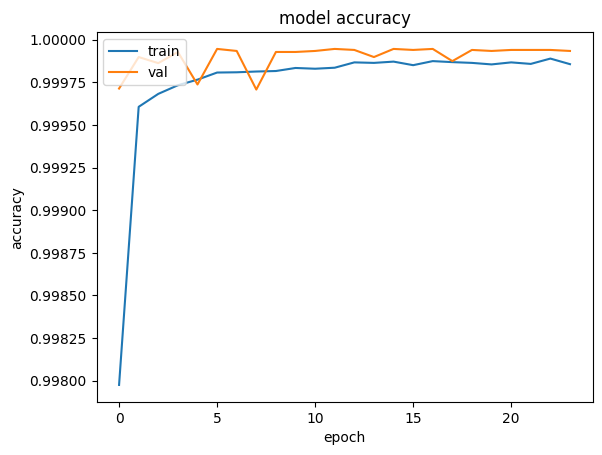

In [22]:
# plot train and validation accuracy
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

**We should see here that that the trained model accuracy agrees with the validation accuracy. Despite of the very high accuracy overfitting is not an issue**

6554/6554 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.9999 - loss: 4.5095e-04
Test Loss: 0.0003
Test Accuracy: 0.9999
6554/6554 ━━━━━━━━━━━━━━━━━━━━ 7s 985us/step

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    152477
           1       1.00      1.00      1.00     57238

    accuracy                           1.00    209715
   macro avg       1.00      1.00      1.00    209715
weighted avg       1.00      1.00      1.00    209715



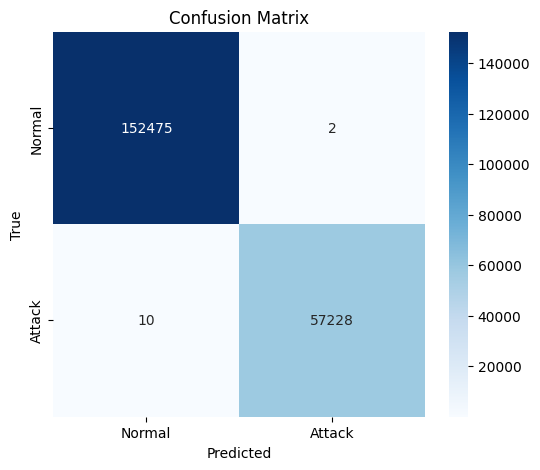

In [23]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test)
print(f"Test Loss: {test_loss:.4f}") #loss function value
print(f"Test Accuracy: {test_accuracy:.4f}") #how many % are predicted correctly?

# Predict on the test data and round probability to
y_pred = (model.predict(X_test_scaled) > 0.5).astype("int32")

# Step 3: Print the classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix using seaborn heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=["Normal", "Attack"], yticklabels=["Normal", "Attack"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


**The confusion matrix with respect to test and predicted labels show there're very few false positives and that most labels are correct!**

<font size=5><a name="6.-Save-model-&-exit">6. Save model & exit</a>[\^](#TOC)</font>

In [24]:
# Save the trained model to Google Drive
#model_path = f'{project_folder}/cic_ids2018_friday.h5'
model_path = f'{project_folder}/cic_ids2018_friday.keras'
model.save(model_path)

print(f"Model saved to: {model_path}")

Model saved to: /content/drive/MyDrive/CIC_IDS2018_test/cic_ids2018_friday.keras


In [25]:
#un-mount drive
drive.flush_and_unmount() #if this fails manually, then just unmount from the left hand side menu!

In [26]:
#print entire notebook runtime
notebook_end_time = time.time()
print(f'Notebook execution took {((notebook_end_time - notebook_start_time)/60.0):.2f} minutes.')

Notebook execution took 30.62 minutes.
